# Notebook de segmentation   
## Adrian Rodriguez   
## Projet 3 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Segmentez-des-clients-d-un-site-e-commerce-Formation-IML   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte


Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

---
# 1. Importation et exploration préliminaire

In [1]:
import pandas as pd

import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly
from IPython.display import Image

from functions import *

pd.options.display.max_columns = None
plt.style.use("default")

In [2]:
# Pour vérifier le respect de la convention PEP8
# Installation conda non diponible. Utiliser pip
%load_ext pycodestyle_magic
%pycodestyle_on

In [3]:
sales_raw = pd.read_csv('src/sales.csv')

In [4]:
sales_raw.shape

(96946, 13)

In [5]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96946 entries, 0 to 96945
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96946 non-null  object 
 1   order_purchase_timestamp  96946 non-null  object 
 2   delivery_respect          96946 non-null  int64  
 3   period                    96946 non-null  object 
 4   customer_unique_id        96946 non-null  object 
 5   n_item                    96946 non-null  float64
 6   main_category_fr          96946 non-null  object 
 7   n_photos_class            96946 non-null  float64
 8   len_desc_class            96946 non-null  float64
 9   ratio_freight_amount      96946 non-null  float64
 10  prefered_payment          96946 non-null  object 
 11  total_paid                96946 non-null  float64
 12  review_score              96946 non-null  int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 9.6+ MB


In [6]:
sales_raw.columns

Index(['order_id', 'order_purchase_timestamp', 'delivery_respect', 'period',
       'customer_unique_id', 'n_item', 'main_category_fr', 'n_photos_class',
       'len_desc_class', 'ratio_freight_amount', 'prefered_payment',
       'total_paid', 'review_score'],
      dtype='object')

In [7]:
sales_raw.dtypes

order_id                     object
order_purchase_timestamp     object
delivery_respect              int64
period                       object
customer_unique_id           object
n_item                      float64
main_category_fr             object
n_photos_class              float64
len_desc_class              float64
ratio_freight_amount        float64
prefered_payment             object
total_paid                  float64
review_score                  int64
dtype: object

In [8]:
sales_raw['order_purchase_timestamp'] = \
    pd.to_datetime(sales_raw['order_purchase_timestamp'],
                   format="%Y-%m-%d %H:%M:%S")

In [9]:
sales_raw.head()

,order_id,order_purchase_timestamp,delivery_respect,period,customer_unique_id,n_item,main_category_fr,n_photos_class,len_desc_class,ratio_freight_amount,prefered_payment,total_paid,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2,2017-Q4,7c396fd4830fd04220f754e42b4e5bff,1.0,Electoménager,3.0,1.0,22.53,voucher,38.71,4
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2,2018-Q3,af07308b275d755c9edb36a90c618231,1.0,Mode Bagage,1.0,1.0,16.09,boleto,141.46,4
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2,2018-Q3,3a653a41f6f9fc3d2a113cf8398680e8,1.0,Auto Moto,1.0,1.0,10.73,credit_card,179.12,5
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2,2017-Q4,7c142cf63193a1473d2e66489a9ae977,1.0,Jardin Animalerie,2.0,2.0,37.67,credit_card,72.20,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2,2018-Q1,72632f0f9dd73dfee390c9b22eb56dd6,1.0,Librairie,3.0,1.0,30.47,credit_card,28.62,5


In [10]:
sales = sales_raw.copy()

---
# 2. Etude RFM
## 2.1 Construction des métriques RFM
La cible à segmenter étant les clients, il est nécessaire de grouper les commandes par clients.

Pour construire les métriques RFM et avoir quelquechose de cohérent, je me place comme si les données étaient récentes, soit au début du 4ème trimestre 2018.

In [11]:
sales.order_purchase_timestamp.max()

Timestamp('2018-09-03 09:06:57')

In [12]:
date = sales.order_purchase_timestamp.max() + dt.timedelta(days=2)
snapshot_date = date.replace(hour=0, minute=0, second=0)
snapshot_date

Timestamp('2018-09-05 00:00:00')

Pour la métrique **Recency**, je calcule la différence en la date de snapshot et la date de commande la plus récente, en nombre de jours.   
Pour la métrique **Frequency**, je compte le nombre de commande.    
Pour la métrique **MonetaryValue**, je prend en compte la valeur du produits, sans les frais de port. Si un client à acheter plusieurs produits, que ce soit dans la même commande ou plusieurs commande, je somme les valeurs des produits

In [13]:
aggdict = {'order_id': 'count',
           'order_purchase_timestamp': lambda x: (snapshot_date
                                                  - x.max()).days,
           'delivery_respect': lambda x: x.value_counts().index[0],
           'n_item': lambda x: x.value_counts().index[0],
           'main_category_fr': lambda x: x.value_counts().index[0],
           'n_photos_class': lambda x: x.value_counts().index[0],
           'len_desc_class': lambda x: x.value_counts().index[0],
           'ratio_freight_amount': 'mean',
           'prefered_payment': lambda x: x.value_counts().index[0],
           'total_paid': 'sum',
           'review_score': lambda x: x.value_counts().index[0]}


customer = sales.groupby('customer_unique_id').agg(aggdict)

columns_rename = {'order_purchase_timestamp': 'recency',
                  'order_id': 'frequency',
                  'total_paid': 'monetary_value'}

customer.rename(columns=columns_rename, inplace=True)

customer

,frequency,recency,delivery_respect,n_item,main_category_fr,n_photos_class,len_desc_class,ratio_freight_amount,prefered_payment,monetary_value,review_score
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,Meuble Déco,1.0,1.0,8.46,credit_card,141.90,5
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,Mode Bagage,1.0,3.0,30.49,credit_card,27.19,4
0000f46a3911fa3c0805444483337064,1,543,2,1.0,Librairie,2.0,1.0,19.97,credit_card,86.22,3
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,Téléphonie,3.0,4.0,40.42,credit_card,43.62,4
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,Téléphonie,2.0,3.0,8.58,credit_card,196.89,5
...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,Mode Bagage,1.0,2.0,24.06,credit_card,2067.42,5
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,Bébé,2.0,2.0,23.28,credit_card,84.58,4
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,Auto Moto,3.0,3.0,20.06,credit_card,112.46,5


In [14]:
customer_RFM = customer.copy()

## 2-2. Segmentation RFM

In [15]:
# Construction des segments
# Je définis R et M en fonction des 4 percentiles
# Je définis F en fonction du nombre de fois ou les client a commandé
# A savoir je groupe les client qui ont commandé 4 fois et plus
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_quartiles = pd.qcut(customer_RFM['recency'], 4, labels=r_labels)
m_quartiles = pd.qcut(customer_RFM['monetary_value'], 4, labels=m_labels)

customer_RFM = customer_RFM.assign(R=r_quartiles.values)

customer_RFM['F'] = customer_RFM.frequency
customer_RFM['F'][customer_RFM.frequency > 3] = 4

customer_RFM = customer_RFM.assign(M=m_quartiles.values)

customer_RFM

,frequency,recency,delivery_respect,n_item,main_category_fr,n_photos_class,len_desc_class,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M
customer_unique_id,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,Meuble Déco,1.0,1.0,8.46,credit_card,141.90,5,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,Mode Bagage,1.0,3.0,30.49,credit_card,27.19,4,4,1,1
0000f46a3911fa3c0805444483337064,1,543,2,1.0,Librairie,2.0,1.0,19.97,credit_card,86.22,3,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,Téléphonie,3.0,4.0,40.42,credit_card,43.62,4,2,1,1
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,Téléphonie,2.0,3.0,8.58,credit_card,196.89,5,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,Mode Bagage,1.0,2.0,24.06,credit_card,2067.42,5,1,1,4
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,Bébé,2.0,2.0,23.28,credit_card,84.58,4,2,1,2
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,Auto Moto,3.0,3.0,20.06,credit_card,112.46,5,1,1,3


In [16]:
customer_RFM['RFM_Segment'] = customer_RFM.apply(join_rfm, axis=1)
customer_RFM['RFM_Score'] = customer_RFM[['R', 'F', 'M']].sum(axis=1)
customer_RFM

,frequency,recency,delivery_respect,n_item,main_category_fr,n_photos_class,len_desc_class,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,Meuble Déco,1.0,1.0,8.46,credit_card,141.90,5,4,1,3,413,8.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,Mode Bagage,1.0,3.0,30.49,credit_card,27.19,4,4,1,1,411,6.0
0000f46a3911fa3c0805444483337064,1,543,2,1.0,Librairie,2.0,1.0,19.97,credit_card,86.22,3,1,1,2,112,4.0
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,Téléphonie,3.0,4.0,40.42,credit_card,43.62,4,2,1,1,211,4.0
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,Téléphonie,2.0,3.0,8.58,credit_card,196.89,5,2,1,4,214,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,Mode Bagage,1.0,2.0,24.06,credit_card,2067.42,5,1,1,4,114,6.0
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,Bébé,2.0,2.0,23.28,credit_card,84.58,4,2,1,2,212,5.0
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,Auto Moto,3.0,3.0,20.06,credit_card,112.46,5,1,1,3,113,5.0


## 2-3. Analyse préliminaire de la segmentation RFM

In [17]:
# 10 premiers segments les plus peuplés
customer_RFM.groupby('RFM_Segment').size().\
    sort_values(ascending=False).head(10)

RFM_Segment
112    6016
413    5960
212    5942
111    5930
411    5870
311    5841
211    5762
313    5705
213    5626
412    5606
dtype: int64

In [18]:
customer_RFM

,frequency,recency,delivery_respect,n_item,main_category_fr,n_photos_class,len_desc_class,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,Meuble Déco,1.0,1.0,8.46,credit_card,141.90,5,4,1,3,413,8.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,Mode Bagage,1.0,3.0,30.49,credit_card,27.19,4,4,1,1,411,6.0
0000f46a3911fa3c0805444483337064,1,543,2,1.0,Librairie,2.0,1.0,19.97,credit_card,86.22,3,1,1,2,112,4.0
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,Téléphonie,3.0,4.0,40.42,credit_card,43.62,4,2,1,1,211,4.0
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,Téléphonie,2.0,3.0,8.58,credit_card,196.89,5,2,1,4,214,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,Mode Bagage,1.0,2.0,24.06,credit_card,2067.42,5,1,1,4,114,6.0
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,Bébé,2.0,2.0,23.28,credit_card,84.58,4,2,1,2,212,5.0
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,Auto Moto,3.0,3.0,20.06,credit_card,112.46,5,1,1,3,113,5.0


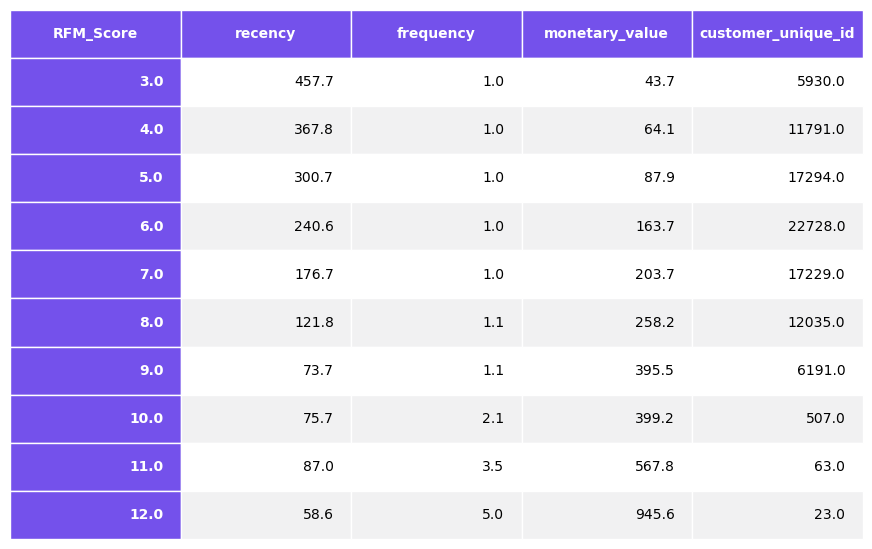

In [19]:
# Valeur des segments
agg_dict = {'recency': 'mean',
            'frequency': 'mean',
            'monetary_value': 'mean',
            'customer_unique_id': 'count'}

score_RFM = customer_RFM.reset_index().groupby('RFM_Score')\
                        .agg(agg_dict).round(1)
export_png_table(score_RFM.reset_index(),
                 filename='img/img_RFM_score.png')

---
# 3. Segmentation non supervisée avec kmeans
Lors du travail exploratoire, j'ai constaté que les clients ne revenait pas sur Olist. Je vais axé ma segmentation en fonction de la statifaction client et des métriques RFM.

In [20]:
col_list = ['recency',
            'frequency',
            'monetary_value',
            'review_score',
            'delivery_respect']

customer_km = customer[col_list].copy()

customer_km.head()

,recency,frequency,monetary_value,review_score,delivery_respect
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90,5,2
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27.19,4,2
0000f46a3911fa3c0805444483337064,543,1,86.22,3,2
0000f6ccb0745a6a4b88665a16c9f078,327,1,43.62,4,2
0004aac84e0df4da2b147fca70cf8255,294,1,196.89,5,2


## 3-1. Transformation des données
J'observe la distribution de mes variables quantitatives

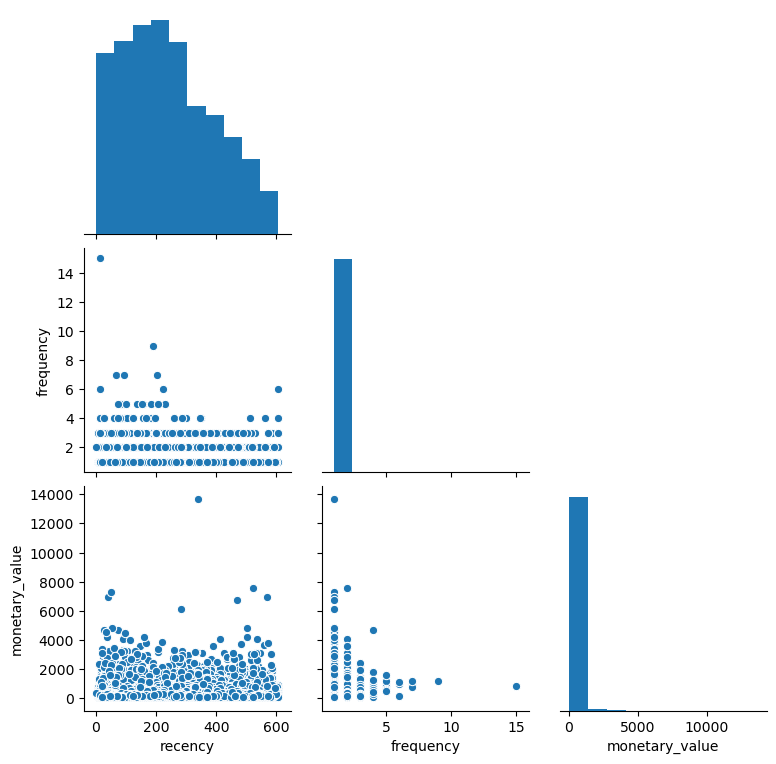

In [21]:
col_pairplot = ['recency', 'frequency', 'monetary_value']
fig = sns.pairplot(customer_km[col_pairplot], corner=True)

fig.savefig('img/img_sales_pairplot.png',
            transparent=True)
plt.close()

Image('img/img_sales_pairplot.png')

Mes distributions n'ont pas une forme gaussienne, je dois les passer au logarithme.

In [22]:
customer_km.isna().sum()

recency             0
frequency           0
monetary_value      0
review_score        0
delivery_respect    0
dtype: int64

In [23]:
log_customer_km = customer_km.copy()

list = ['recency', 'frequency', 'monetary_value']
for i in list:
    log_customer_km[i + '_log'] = np.log(customer_km[i])
    log_customer_km.drop(i, axis=1, inplace=True)

In [24]:
scaler = StandardScaler()
std_customer_km = scaler.fit_transform(log_customer_km)

std_customer_km = pd.DataFrame(std_customer_km,
                               index=log_customer_km.index,
                               columns=log_customer_km.columns)
std_customer_km

,review_score,delivery_respect,recency_log,frequency_log,monetary_value_log
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.678193,0.3131,-0.509195,-0.173009,0.286660
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.066732,0.3131,-0.480175,-0.173009,-1.731537
0000f46a3911fa3c0805444483337064,-0.811657,0.3131,1.250195,-0.173009,-0.321900
0000f6ccb0745a6a4b88665a16c9f078,-0.066732,0.3131,0.668885,-0.173009,-1.154191
0004aac84e0df4da2b147fca70cf8255,0.678193,0.3131,0.546949,-0.173009,0.686718
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.678193,0.3131,1.042479,-0.173009,3.558890
fffea47cd6d3cc0a88bd621562a9d061,-0.066732,0.3131,0.440816,-0.173009,-0.345357
ffff371b4d645b6ecea244b27531430a,0.678193,0.3131,1.313834,-0.173009,0.002638


## 3-2. Définition du nombre de clusters
3 methodes pour définir le nombre de cluster :
- Méthode visuelle avec Elbow criterion
- Méthode mathématique avec silhouette

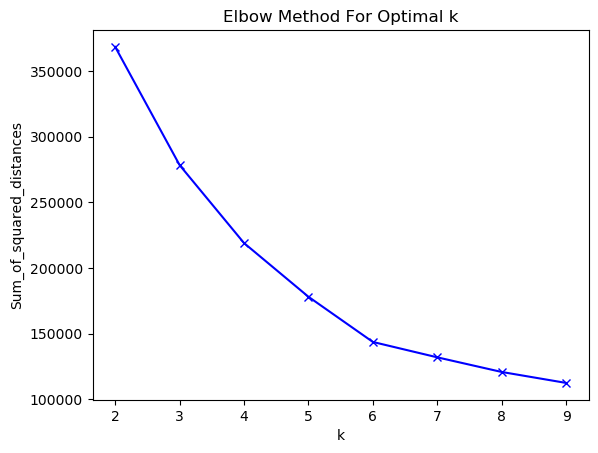

In [25]:
# Méthode visuelle
Sum_of_squared_distances = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(std_customer_km)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plt.savefig('img/img_elbow_kmeans.png',
            transparent=True)

Nombre de cluster en cours de traitement :  2
Nombre de cluster en cours de traitement :  3
Nombre de cluster en cours de traitement :  4
Nombre de cluster en cours de traitement :  5
Nombre de cluster en cours de traitement :  6
Nombre de cluster en cours de traitement :  7
Nombre de cluster en cours de traitement :  8
Nombre de cluster en cours de traitement :  9


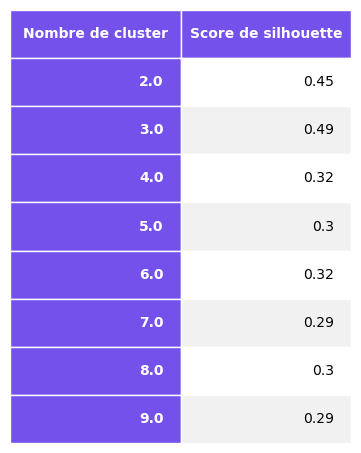

In [26]:
# Méthode mathématiques
silhouette = []
K = range(2, 10)
for k in K:
    print(f'Nombre de cluster en cours de traitement :  {k}')
    km = KMeans(n_clusters=k)
    km = km.fit(std_customer_km)
    score = round(silhouette_score(std_customer_km, km.labels_), 2)
    silhouette.append(score)

silh_dict = {'Nombre de cluster': K,
             'Score de silhouette': silhouette}
silhouette_df = pd.DataFrame(data=silh_dict)
export_png_table(silhouette_df,
                 filename='img/img_silhouette_score.png')

Le nombre idéal de clusters est de 6.

In [27]:
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(std_customer_km)
cluster_labels = kmeans.labels_

## 3-3. Etudes des centroîdes

In [28]:
# Intégration des centroïdes dans un dataframe
ctds = pd.DataFrame(kmeans.cluster_centers_,
                    columns=std_customer_km.columns)
ctds = ctds.reset_index().rename(columns={'index': 'cluster'})
ctds

,cluster,review_score,delivery_respect,recency_log,frequency_log,monetary_value_log
0,0,0.007577,0.241631,-0.083636,5.546647,0.911968
1,1,0.451380,0.304491,0.368385,-0.173009,0.917907
2,2,-1.690563,0.313100,0.187407,-0.173009,0.117218
3,3,0.393892,0.231723,-1.691576,-0.173009,-0.108445
4,4,0.427051,0.309964,0.433488,-0.173009,-0.763857
5,5,-1.403141,-2.875809,0.128370,-0.173009,0.067443


In [29]:
# Intégration des centroïdes dans un dataframe
ctds = pd.DataFrame(kmeans.cluster_centers_,
                    columns=std_customer_km.columns)
ctds = ctds.reset_index().rename(columns={'index': 'cluster'})

# Récupération des spécificités des centroïdes
several_orders = ctds.sort_values(by='frequency_log')\
                        .tail(1).cluster.iloc[0]

recent_order = ctds.sort_values(by='monetary_value_log')\
                    .head(2).cluster.iloc[1]

low_value = ctds.sort_values(by='monetary_value_log')\
                .head(1).cluster.iloc[0]

c_fix = ['delivery_respect', 'review_score']
ctds['fix_customer'] = ctds[c_fix].sum(axis=1)
bad_score = ctds.sort_values(by='fix_customer')\
                .head(2).cluster.iloc[1]

ctds['fix_customer'] = ctds[c_fix].sum(axis=1)
bad_delivery = ctds.sort_values(by='fix_customer')\
                    .head(1).cluster.iloc[0]

c_top = ['review_score', 'monetary_value_log']
ctds['top_customer'] = ctds[c_top].sum(axis=1)
top_customer = ctds.sort_values(by='top_customer')\
                    .tail(1).cluster.iloc[0]

# Création du dictionnaire des cluster
dict_cluster = {'2.Client actif': several_orders,
                '5.Client non livré/en retard': bad_delivery,
                '6.Client mécontent': bad_score,
                '3.Client récent': recent_order,
                '4.Client à faible valeur': low_value,
                '1.Top client': top_customer}

ctds['cluster_name'] = np.nan

for i, n in dict_cluster.items():
    ctds['cluster_name'][ctds.cluster == n] = i

round(ctds, 2)

,cluster,review_score,delivery_respect,recency_log,frequency_log,monetary_value_log,fix_customer,top_customer,cluster_name
0,0,0.01,0.24,-0.08,5.55,0.91,0.25,0.92,2.Client actif
1,1,0.45,0.30,0.37,-0.17,0.92,0.76,1.37,1.Top client
2,2,-1.69,0.31,0.19,-0.17,0.12,-1.38,-1.57,6.Client mécontent
3,3,0.39,0.23,-1.69,-0.17,-0.11,0.63,0.29,3.Client récent
4,4,0.43,0.31,0.43,-0.17,-0.76,0.74,-0.34,4.Client à faible valeur
5,5,-1.40,-2.88,0.13,-0.17,0.07,-4.28,-1.34,5.Client non livré/en retard


In [30]:
ctds.drop(columns=['fix_customer', 'top_customer'], inplace=True)

In [31]:
std_customer_km = affect_cluster_name(std_customer_km,
                                      cluster_labels,
                                      dict_cluster)
std_customer_km.head()

,review_score,delivery_respect,recency_log,frequency_log,monetary_value_log,cluster_name
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.678193,0.3131,-0.509195,-0.173009,0.286660,1.Top client
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.066732,0.3131,-0.480175,-0.173009,-1.731537,4.Client à faible valeur
0000f46a3911fa3c0805444483337064,-0.811657,0.3131,1.250195,-0.173009,-0.321900,6.Client mécontent
0000f6ccb0745a6a4b88665a16c9f078,-0.066732,0.3131,0.668885,-0.173009,-1.154191,4.Client à faible valeur
0004aac84e0df4da2b147fca70cf8255,0.678193,0.3131,0.546949,-0.173009,0.686718,1.Top client


## 3-4. Projection des clusters
### 3-4-1. PCA

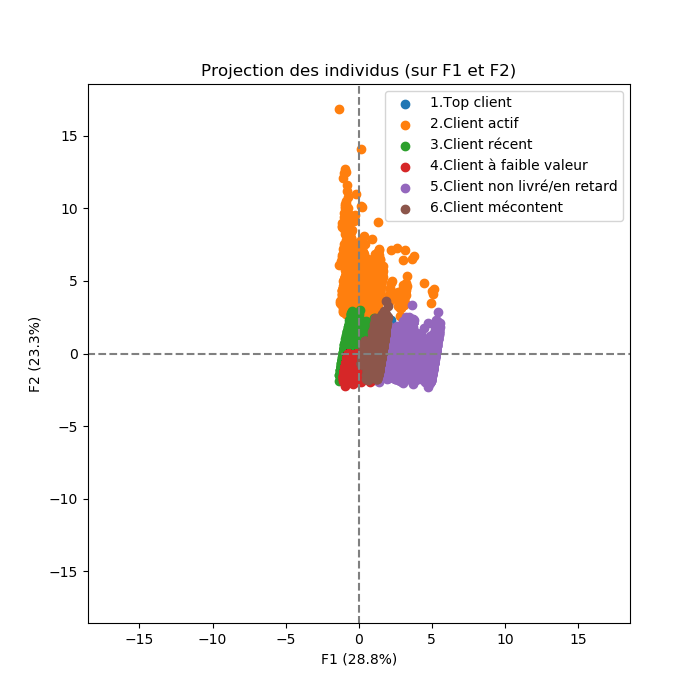

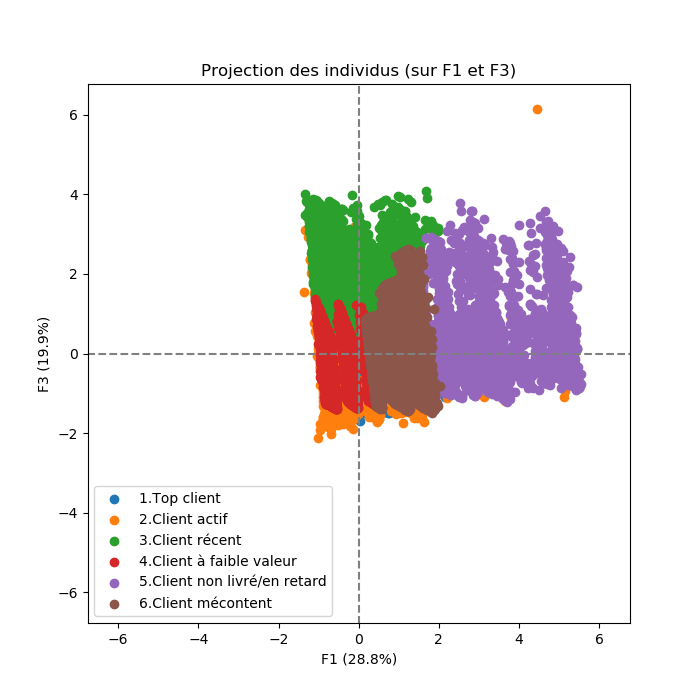

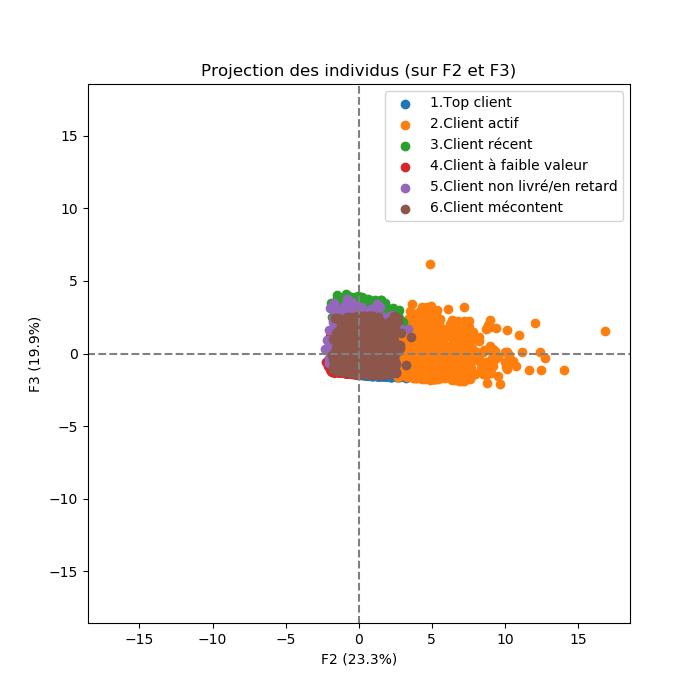

In [32]:
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(std_customer_km.drop(columns='cluster_name'))
X_projected = pca.transform(std_customer_km.drop(columns='cluster_name'))

display_factorial_planes(X_projected,
                         n_comp,
                         pca,
                         [(0, 1), (0, 2), (1, 2)],
                         illustrative_var=std_customer_km['cluster_name'],
                         png_filename='img/img_projection_clusters')

### 3-4-2. t-SNE

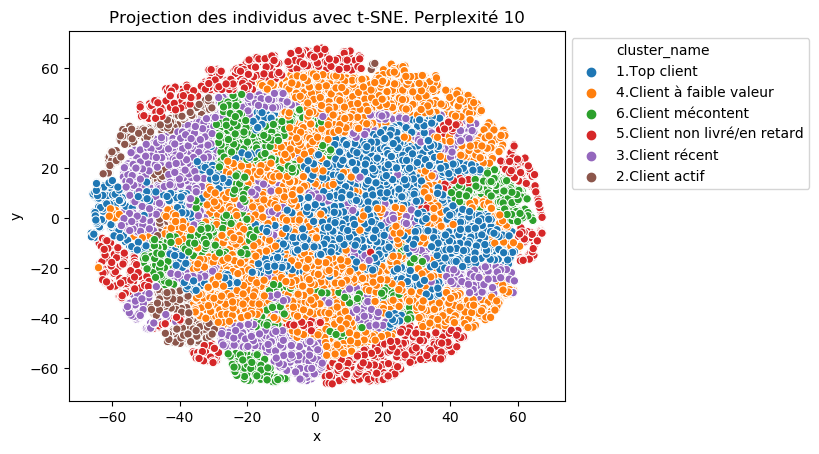

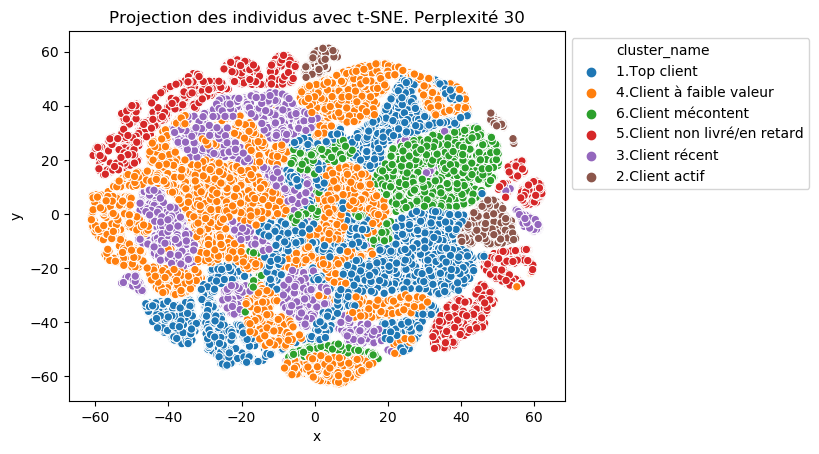

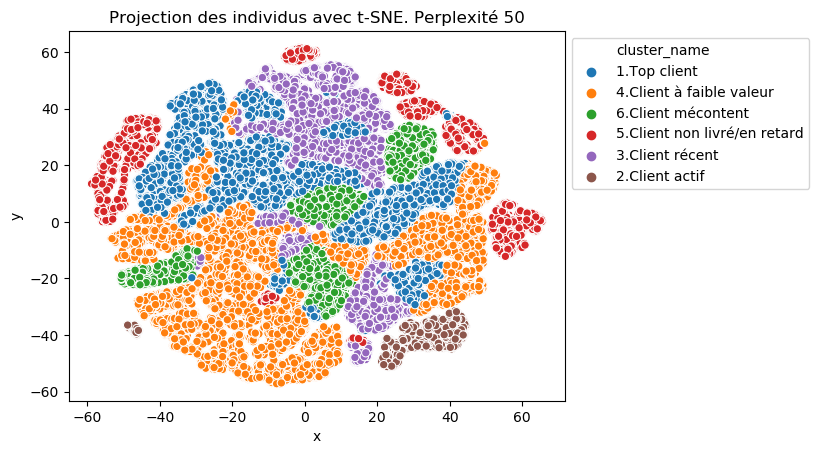

In [33]:
perplexity = [10, 30, 50]

for perp in perplexity:
    tsne = TSNE(perplexity=perp)
    customer_tsne = std_customer_km.copy()
    tsne_feat = tsne.fit_transform(customer_tsne.drop(columns='cluster_name'))

    # Assignation des features
    customer_tsne['x'] = tsne_feat[:, 0]
    customer_tsne['y'] = tsne_feat[:, 1]

    # Visualisation des résultats
    plt.clf()
    sns.scatterplot(x="x", y="y", data=customer_tsne, hue='cluster_name')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('Projection des individus avec t-SNE. Perplexité ' + str(perp))

    plt.savefig('img/img_tsne-perp' + str(perp) + '.png',
                transparent=True,
                bbox_inches="tight")
    plt.close()

    display(Image('img/img_tsne-perp' + str(perp) + '.png'))

## 3-5. Importances des attributs
### 3-5-1. Méthode visuelle avec snake plot

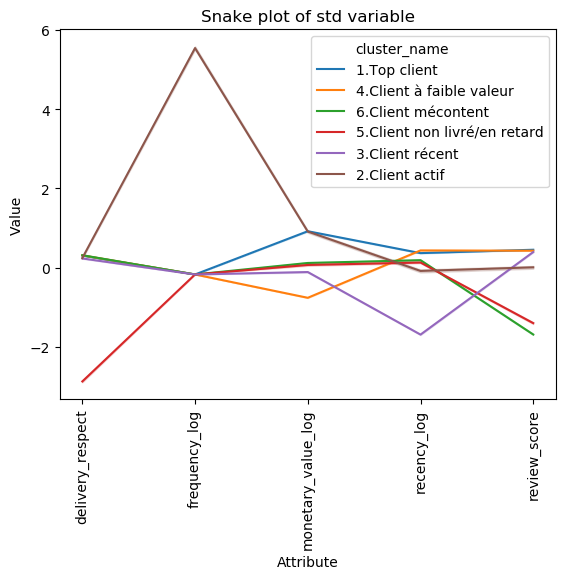

In [34]:
std_customer_melt = pd.melt(std_customer_km.reset_index(),
                            id_vars=['customer_unique_id', 'cluster_name'],
                            value_vars=['recency_log',
                                        'frequency_log',
                                        'monetary_value_log',
                                        'delivery_respect',
                                        'review_score'],
                            var_name='Attribute',
                            value_name='Value')

plt.clf()

plt.subplot()
plt.title('Snake plot of std variable')
sns.lineplot(x='Attribute',
             y='Value',
             hue='cluster_name',
             data=std_customer_melt)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1))

plt.savefig('img/img_snake_plot.png',
            transparent=True,
            bbox_inches="tight")

### 3-5-2. Méthode mathématique

In [35]:
customer_km = affect_cluster_name(customer_km, cluster_labels, dict_cluster)
customer_km.head()

,recency,frequency,monetary_value,review_score,delivery_respect,cluster_name
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90,5,2,1.Top client
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27.19,4,2,4.Client à faible valeur
0000f46a3911fa3c0805444483337064,543,1,86.22,3,2,6.Client mécontent
0000f6ccb0745a6a4b88665a16c9f078,327,1,43.62,4,2,4.Client à faible valeur
0004aac84e0df4da2b147fca70cf8255,294,1,196.89,5,2,1.Top client


<Figure size 640x480 with 0 Axes>

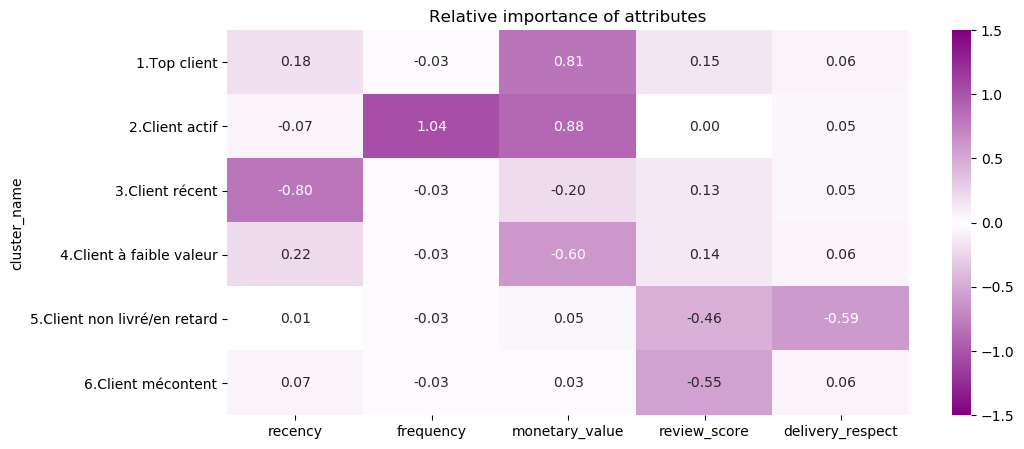

In [36]:
cluster_avg = customer_km.groupby('cluster_name').mean()
population_avg = customer_km.drop(columns='cluster_name').mean()

relative_imp = (cluster_avg / population_avg).round(2)
relative_imp = relative_imp - 1

plt.clf()
plt.figure(figsize=(11, 5))
plt.title('Relative importance of attributes')
cmap = LinearSegmentedColormap.from_list(name='test',
                                         colors=['purple', 'white', 'purple'])
sns.heatmap(data=relative_imp,
            annot=True,
            fmt='.2f',
            cmap=cmap,
            vmin=-1.5,
            vmax=1.5)

plt.savefig('img/img_relative_imp.png',
            transparent=True,
            bbox_inches="tight")

## 3-6. Analyse de la segmentation non supervisée sur les données originales

In [37]:
customer_RFM = affect_cluster_name(customer_RFM, cluster_labels, dict_cluster)
customer_RFM.head()

,frequency,recency,delivery_respect,n_item,main_category_fr,n_photos_class,len_desc_class,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M,RFM_Segment,RFM_Score,cluster_name
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,Meuble Déco,1.0,1.0,8.46,credit_card,141.90,5,4,1,3,413,8.0,1.Top client
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,Mode Bagage,1.0,3.0,30.49,credit_card,27.19,4,4,1,1,411,6.0,4.Client à faible valeur
0000f46a3911fa3c0805444483337064,1,543,2,1.0,Librairie,2.0,1.0,19.97,credit_card,86.22,3,1,1,2,112,4.0,6.Client mécontent
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,Téléphonie,3.0,4.0,40.42,credit_card,43.62,4,2,1,1,211,4.0,4.Client à faible valeur
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,Téléphonie,2.0,3.0,8.58,credit_card,196.89,5,2,1,4,214,7.0,1.Top client


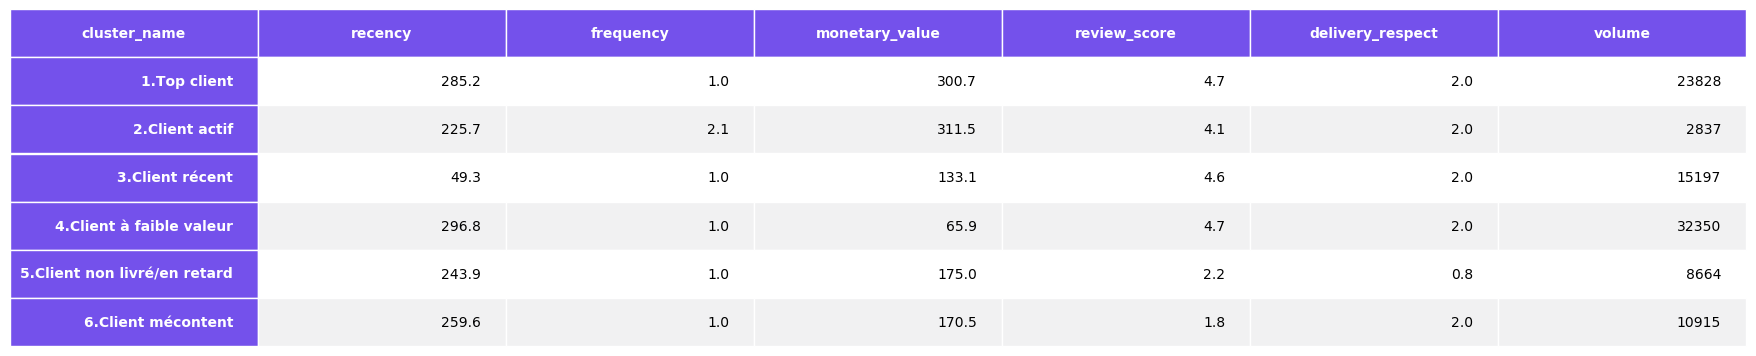

In [38]:
aggdict = {'recency': 'mean',
           'frequency': 'mean',
           'monetary_value': 'mean',
           'review_score': 'mean',
           'delivery_respect': 'mean',
           'n_item': 'count'}

sort = ['review_score', 'delivery_respect', 'monetary_value']

seg_customer = customer_RFM.groupby('cluster_name')\
                           .agg(aggdict)\
                           .round(1)

seg_customer = seg_customer.rename(columns={'n_item': 'volume'})

export_png_table(seg_customer.reset_index(),
                 col_width=3.2,
                 filename='img/img_seg_customer.png')

# 4. Export CSV

In [39]:
customer_RFM.to_csv('src/persona.csv')